#  Risco de Crédito Alemão (German Credit Risk)

## Sobre o conjunto de dados
O conjunto de dados original contém 1000 entradas com 20 atributos categoriais/simbólicos preparados pelo Prof. Hofmann. Neste conjunto de dados, cada entrada representa uma pessoa que recebe um crédito de um banco. Cada pessoa é classificada como risco de crédito bom ou ruim de acordo com o conjunto de atributos. O link para o conjunto de dados original pode ser encontrado abaixo.

É quase impossível entender o conjunto de dados original devido ao seu complicado sistema de categorias e símbolos. Assim, escrevi um pequeno script Python para convertê-lo em um arquivo CSV legível. Várias colunas são simplesmente ignoradas porque, na minha opinião, ou não são importantes ou suas descrições são obscuras. Os atributos selecionados são:

> + **Age** - (Idade) (numérico)
> + **Sex** - (Sexo) (texto: masculino, feminino)
> + **Job** - (Trabalho) (numérico: 0 - não qualificado e não residente, 1 - não qualificado e residente, 2 - > + qualificado, 3 - altamente qualificado)
> + **Housing** - (Moradia) (texto: própria, alugada ou gratuita)
> + **Saving accounts** - (Contas de poupança) (texto - pouco, moderado, bastante rico, rico)
> + **Checking account**  - (Conta corrente) (numérica, em DM - Deutsch Mark)
> + **Credit amount** - (Valor do crédito) (numérico, em DM)
> + **Duration** - (Duração) (numérica, em mês)
> + **Purpose** - (Objetivo) (texto: carro, móveis/equipamentos, rádio/TV, eletrodomésticos, consertos, educação, negócios, férias/outros)


## Inicializando o PySpark

In [25]:
import findspark
import pyspark
from pyspark.sql import SparkSession

# Faz a Interafce entre o Spark e o Jupyter Notebook
findspark.init()

# Inicializando uma Sessão no Spark
spark = SparkSession.builder.appName("RandomForest").getOrCreate()

---

## Aplicando Regressão com RandomForest no DataSet Carros



### Carregando o Cunjunto de Dados Carros

In [26]:
german_data = spark.read.csv("german_credit_data.csv",
                             header=True, inferSchema=True, sep=",")
print(f"Quantidade de Registros do Dataset: {german_data.count()}")
german_data.show(5, truncate=False)

Quantidade de Registros do Dataset: 1000
+-----+---+------+---+-------+---------------+----------------+-------------+--------+-------------------+
|index|Age|Sex   |Job|Housing|Saving_accounts|Checking_account|Credit_amount|Duration|Purpose            |
+-----+---+------+---+-------+---------------+----------------+-------------+--------+-------------------+
|0    |67 |male  |2  |own    |NA             |little          |1169         |6       |radio/TV           |
|1    |22 |female|2  |own    |little         |moderate        |5951         |48      |radio/TV           |
|2    |49 |male  |1  |own    |little         |NA              |2096         |12      |education          |
|3    |45 |male  |2  |free   |little         |little          |7882         |42      |furniture/equipment|
|4    |53 |male  |2  |free   |little         |little          |4870         |24      |car                |
+-----+---+------+---+-------+---------------+----------------+-------------+--------+-----------------

In [28]:
german_data.select("Age", "Sex", "Saving_accounts", "Checking_account", "Credit_amount").show(5, truncate=False)

+---+------+---------------+----------------+-------------+
|Age|Sex   |Saving_accounts|Checking_account|Credit_amount|
+---+------+---------------+----------------+-------------+
|67 |male  |NA             |little          |1169         |
|22 |female|little         |moderate        |5951         |
|49 |male  |little         |NA              |2096         |
|45 |male  |little         |little          |7882         |
|53 |male  |little         |little          |4870         |
+---+------+---------------+----------------+-------------+
only showing top 5 rows



### Escolha das Variáveis Independentes e Dependente para treinamento do Modelo

Para esse exemplo, as variáveis dependentes serão os atritutos  **Consumo | Cilindros | Cilindradas |** e a variável Dependente será o Atributo **| HP |**

ou seja, vamos usar as variáveis independentes para prever a dependente, para isso, vamos treinar o modelo com os dados do dataset.

### Importação do Módulo do PySpark Para o Pré-Processamento dos Dados

In [21]:
from pyspark.ml.feature import RFormula

In [66]:
# Colocando os dados no Formato de dataframe do Spark usando o RFormula
rformula = RFormula(formula="Credit_amount ~ Age + Sex + Saving_accounts + Checking_account",
                    featuresCol="independentes", labelCol="dependente")

german_data_rf = rformula.fit(german_data).transform(german_data)
german_data_rf.select("independentes", "dependente").show(5, truncate=False)

+--------------------------------+----------+
|independentes                   |dependente|
+--------------------------------+----------+
|(9,[0,1,3,7],[67.0,1.0,1.0,1.0])|1169.0    |
|(9,[0,2,8],[22.0,1.0,1.0])      |5951.0    |
|(9,[0,1,2,6],[49.0,1.0,1.0,1.0])|2096.0    |
|(9,[0,1,2,7],[45.0,1.0,1.0,1.0])|7882.0    |
|(9,[0,1,2,7],[53.0,1.0,1.0,1.0])|4870.0    |
+--------------------------------+----------+
only showing top 5 rows



In [67]:
from pyspark.ml.feature import Normalizer

In [68]:
# normalizador = Normalizer(inputCol="independentes", outputCol="independentes_norm", p=1.0)
# german_data_norm = normalizador.transform(german_data_rf)
# german_data_norm.select("independentes", "independentes_norm", "dependente").show(5, truncate=True)
german_data_norm = german_data_rf
# normalizador1 = Normalizer(inputCol="dependente", outputCol="dependente_norm", p=1.0)
# german_data_norm = normalizador1.transform(german_data_norm)
# german_data_norm.select("independentes", "dependente_norm", "dependente", "independentes_norm", "dependente").show(5, truncate=False)

### Separando os Dados entre conjunto de Treino e Teste

O Conjunto de dados serão separados entre treino e teste, sendo que **80%** será para treinar o modelo e **20%** para testar o modelo.

In [69]:
german_data_train, german_data_test = german_data_norm.randomSplit([0.8, 0.2], seed=1)
print(f"Quantidade de Dados de Treino: {german_data_train.count()}")
print(f"Quantidade de Dados de Teste: {german_data_test.count()}")

Quantidade de Dados de Treino: 821
Quantidade de Dados de Teste: 179


# Criando o Modelo com Random Forest

---

### Importação do Módulo do PySpark Para Criação do Modelo de Random Forest

In [70]:
from pyspark.ml.regression import RandomForestRegressor

#### Instanciando Objeto e criando o Modelo

In [72]:
# Instanciando o objeto LinearRegression
obj_rfr = RandomForestRegressor(featuresCol="independentes",
                                labelCol="dependente", maxDepth=20,
                                numTrees=1000, seed=20)

# Criando o Modelo
model_rfr = obj_rfr.fit(german_data_train)

23/03/04 16:01:59 WARN DAGScheduler: Broadcasting large task binary with size 1198.1 KiB


23/03/04 16:02:03 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/03/04 16:02:09 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/03/04 16:02:11 WARN DAGScheduler: Broadcasting large task binary with size 1101.3 KiB


23/03/04 16:02:15 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


23/03/04 16:02:19 WARN DAGScheduler: Broadcasting large task binary with size 1475.6 KiB


23/03/04 16:02:24 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


23/03/04 16:02:28 WARN DAGScheduler: Broadcasting large task binary with size 1681.7 KiB


23/03/04 16:02:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
23/03/04 16:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1660.2 KiB


23/03/04 16:02:38 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


23/03/04 16:02:41 WARN DAGScheduler: Broadcasting large task binary with size 1386.1 KiB


23/03/04 16:02:46 WARN DAGScheduler: Broadcasting large task binary with size 17.5 MiB


23/03/04 16:02:52 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB


23/03/04 16:02:58 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB


23/03/04 16:03:04 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


23/03/04 16:03:10 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


23/03/04 16:03:13 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/03/04 16:03:14 WARN DAGScheduler: Broadcasting large task binary with size 1212.7 KiB


#### Realizando Presição com o Modelo Criado

In [74]:
previsao_test = model_rfr.transform(german_data_test)
previsao_test.select("dependente", "prediction").show(5)

+----------+------------------+
|dependente|        prediction|
+----------+------------------+
|    4870.0| 3755.578884881118|
|    1199.0|3194.7144986291055|
|    1403.0| 2750.393561243689|
|    1282.0|2220.8457425704055|
|    8072.0|3124.5151934679207|
+----------+------------------+
only showing top 5 rows



### Avaliando o Modelo

In [75]:
from pyspark.ml.evaluation import RegressionEvaluator

In [77]:
avaliar = RegressionEvaluator(predictionCol="prediction",
                              labelCol="dependente",
                              metricName="rmse")
rmse = avaliar.evaluate(previsao_test)
print(f"rmse: {rmse}")

rmse: 2603.238539847055


O **desvio quadrático médio** ou **erro quadrático médio** é uma medida frequentemente usada das diferenças entre os valores previstos por um modelo ou estimador e os valores observados. dessa forma, quanto menor for esse valor melhor o modelo.

Para o modelo avaliado nesse exemplo, podemos observar que esse valor é relativamente grande, isso ocorre por conta do tamanho do conjunto de dados que é pequeno.

---

## Visualização Gráfica dos Dados (Reais vs Previsão) do Conjunto de Treino

In [78]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

In [79]:
previsao_train = model_rfr.transform(german_data_train)
previsao_train.select("dependente",
                      "prediction",
                      "Age").show(5)

+----------+------------------+---+
|dependente|        prediction|Age|
+----------+------------------+---+
|    1169.0| 3630.540369034395| 67|
|    5951.0|3229.4277808260085| 22|
|    2096.0|2496.9372193247104| 49|
|    7882.0|3990.1514257939393| 45|
|    9055.0| 3932.646582801099| 35|
+----------+------------------+---+
only showing top 5 rows



### Convertendo os Dados Para Array NumPy

In [80]:
previsao_train_numpy = previsao_train.select("dependente",
                                             "prediction",
                                             "Age")
previsao_train_numpy.show(5)
previsao_train_numpy = previsao_train_numpy.toPandas().to_numpy()

previsao_train_numpy.shape

+----------+------------------+---+
|dependente|        prediction|Age|
+----------+------------------+---+
|    1169.0| 3630.540369034395| 67|
|    5951.0|3229.4277808260085| 22|
|    2096.0|2496.9372193247104| 49|
|    7882.0|3990.1514257939393| 45|
|    9055.0| 3932.646582801099| 35|
+----------+------------------+---+
only showing top 5 rows



(821, 3)

### Plotagem dos Gráficos para Compar os Valores Reais com os Estimados pelo Modelo

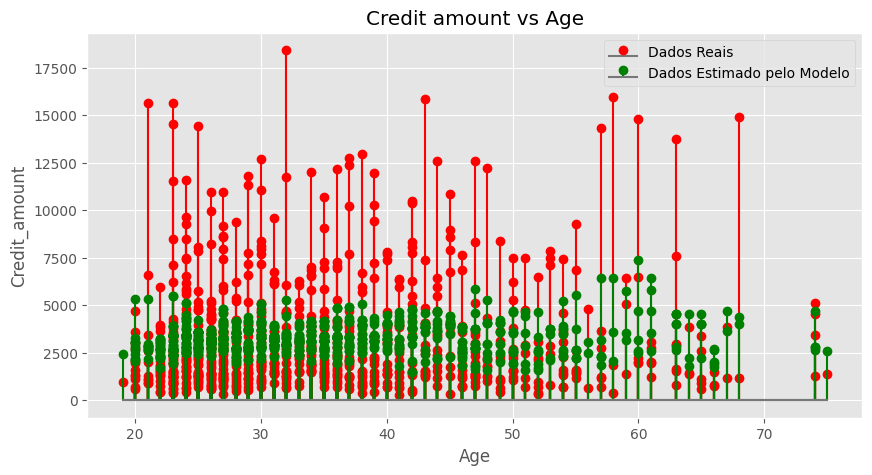

In [84]:
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.stem(previsao_train_numpy[:, 2], previsao_train_numpy[:, 0],
         "r", markerfmt="ro", label="Dados Reais")
ax1.stem(previsao_train_numpy[:, 2], previsao_train_numpy[:, 1],
         "g", markerfmt="go", label="Dados Estimado pelo Modelo")
plt.title("Credit amount vs Age")
ax1.set_xlabel("Age")
ax1.set_ylabel("Credit_amount")
ax1.legend()
plt.show()

---

## Visualização Gráfica dos Dados (Reais vs Previsão) do Conjunto de Testes

### Convertendo os Dados Para Array NumPy

In [85]:
previsao_test_numpy = previsao_test.select("dependente",
                                           "prediction",
                                           "Age")
previsao_test_numpy.show(5)
previsao_test_numpy = previsao_test_numpy.toPandas().to_numpy()

previsao_test_numpy.shape

+----------+------------------+---+
|dependente|        prediction|Age|
+----------+------------------+---+
|    4870.0| 3755.578884881118| 53|
|    1199.0|3194.7144986291055| 60|
|    1403.0| 2750.393561243689| 28|
|    1282.0|2220.8457425704055| 32|
|    8072.0|3124.5151934679207| 25|
+----------+------------------+---+
only showing top 5 rows



(179, 3)

### Plotagem dos Gráficos para Compar os Valores Reais com os Estimados pelo Modelo

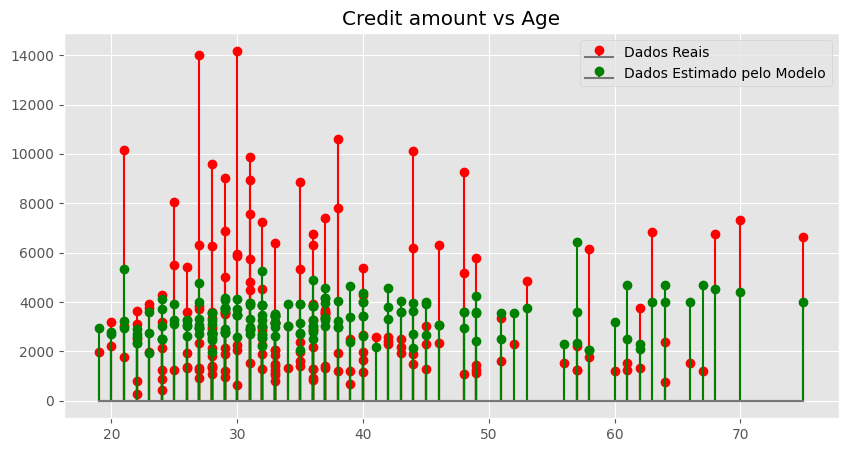

In [88]:
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.stem(previsao_test_numpy[:, 2], previsao_test_numpy[:, 0],
         "r", markerfmt="ro", label="Dados Reais")
ax2.stem(previsao_test_numpy[:, 2], previsao_test_numpy[:, 1],
         "g", markerfmt="go", label="Dados Estimado pelo Modelo")
plt.title("Credit amount vs Age")
ax1.set_xlabel("Age")
ax1.set_ylabel("Credit_amount")
ax2.legend()
plt.show()